# 会議割り当て問題

会議割り当て問題は、複数の会議のスケジュールと複数の会議室が与えられている場合に、なるべく多くの会議が開催できるように会議室を割り当てる問題です。本課題では、この問題に対応したQUBO模型を構築し、アニーリングマシンにより問題を解くことを考えます。

まず、データとして、各会議の開始時間と終了時間が与えられているとします。ここでは時間は文字列で `"10:40"` の形式で与えられているとします。さらにデータとして、会議名をキーとし、その会議の開始・終了時間のリストを値とした辞書で会議スケジュールの情報を持つことにします。また、会議の数と、利用可能な会議室の数も定義しておきます。

In [1]:
# 会議のスケジュール
schedules = {
    "meeting1": ["10:00", "13:00"],
    "meeting2": ["10:00", "12:00"],
    "meeting3": ["10:00", "11:00"],
    "meeting4": ["11:00", "13:00"],
    "meeting5": ["11:00", "12:00"],
    "meeting6": ["11:00", "15:00"],
    "meeting7": ["12:00", "16:00"],
    "meeting8": ["12:00", "15:00"],
    "meeting9": ["13:00", "15:00"],
    "meeting10": ["13:00", "14:00"],
    "meeting11": ["14:00", "17:00"],
    "meeting12": ["15:00", "19:00"],
    "meeting13": ["15:00", "17:00"],
    "meeting14": ["15:00", "16:00"],
    "meeting15": ["16:00", "18:00"],
    "meeting16": ["16:00", "18:00"],
    "meeting17": ["17:00", "19:00"],
    "meeting18": ["17:00", "18:00"],
    "meeting19": ["18:00", "19:00"],
}

# 会議の数
Nm = len(schedules)

# 会議室の数
Nr = 8

次に、会議の時間を比べるために、与えられた時刻を数値で返す関数 `time2num` と、二つの会議のスケジュールが重なりあうかどうかをチェックする関数 `check_overlap` を用意します。

In [2]:
# 時刻を時間単位の数値に変換
def time2num(time: str):
    h, m = map(float, time.split(":"))
    return h + m / 60


# 2つの会議時間に重なりがあるかをチェック
def check_overlap(time_slot1, time_slot2):
    start1, end1 = map(time2num, time_slot1)
    start2, end2 = map(time2num, time_slot2)

    return start1 < end2 and start2 < end1

これで与えられた会議の情報を数値化する準備が整いました。次に、どのようにしてこの問題を組合せ最適化問題として表現するかを考えます。

まず基本方針として、各会議がどの会議室で開催されるかを変数で表すことを考えます。しかし、QUBO変数やイジング変数のような二値変数では任意の数の状態を持つことが出来ません。そこで、各会議に会議室の数だけ決定変数を割り当てます。

例えば、会議 $i$ を 会議室 $r$ で行うことを表す変数を $q_{i, r}$ とします。$q_{i, r} = 1$ であれば会議 $i$ を会議室 $r$ に割り当て、$q_{i, r} = 0$ であれば割り当てないと考えることができます。


|会議 \ 会議室| $0$ | $1$ | ... | $N_r-1$|  
|:---:|:---:|:---:|:---:|:---:|
|$0$| $q_{0,0}$ | $q_{0,1}$ | ... | $q_{0,N_r-1}$|
|$1$| $q_{1,0}$ | $q_{1,1}$ | ... | $q_{1,N_r-1}$|
|$\vdots$| $\vdots$ | $\vdots$ | ... | $\vdots$|
|$N_m -1$| $q_{N_m-1,0}$ | $q_{N_m-1,1}$ | ... | $q_{N_m-1,N_r-1}$|

次に、同じ会議室には複数の会議を重ねて割り当てることができないという制約について考えます。

スケジュールの重なりのある会議をまとめたリストを構築しておきます。例えば、会議 $i$ と $j$ にスケジュールの重なりがある場合、タプル $(i, j)$ を構築し、このリストに格納します。「スケジュールの重なりが無いように各会議を会議室に割り当てる問題」は、「二つの会議 $(i, j)$ が上記のリストに含まれる場合、同じ会議室を割り当てないように会議を配置する問題」となります。

次のようにして、上記に定義した `check_overlap` 関数を用いて会議のスケジュールの重なりを調べ、それをもとにスケジュールに重なりがある二つの会議 $(i, j)$ を `overlaps` リストに追加していきます。

In [3]:
import itertools

# 会議名のリストを取得
mtg_names = list(schedules.keys())

# 会議室名とインデックスの辞書を作成
mtg_name2idx = {mtg_names[i]: i for i in range(Nm)}

# スケジュールの重なりがある会議のインデックスをタプルで格納
overlaps = []
for mtg1, mtg2 in itertools.combinations(mtg_names, 2):
    if check_overlap(schedules[mtg1], schedules[mtg2]):
        overlaps.append(tuple(sorted([mtg_name2idx[mtg1], mtg_name2idx[mtg2]])))

次に、`Nm` 個ある会議それぞれに `Nr` 個の会議室を対応させた、 `Nm` × `Nr` 個のQUBO変数を定義します。会議のインデックス $i$、会議室のインデックス $r$ に対応する変数を $q_{i, r}$ とします。

In [4]:
from amplify import BinarySymbolGenerator

# 決定変数を (Nm x Nr) の配列の形式で定義
gen = BinarySymbolGenerator()
q = gen.array(Nm, Nr)

QUBO変数を用いて制約条件を作成します。

まず、一つの会議は一つの会議室に割り当てられる必要があるので、

$
\displaystyle\sum_{r=0}^{\text{Nr} - 1}q_{i, r} = 1
$

という one-hot 制約を課します。



In [8]:
from amplify.constraint import one_hot

room_constraints = sum([one_hot(q[i]) for i in range(Nm)])

さらに、二つの会議のインデックス $(i, j)$ が、 先ほど定義した会議スケジュールの重なりリスト `overlaps` に含まれている場合は、同じ会議室を割り当てることができないという制約を与える必要があります。

これは $(i, j)\in \text{overlaps}$ の場合は、$q_{i, r}$ と $q_{j, r}$ が同時に $1$ にならないという制約条件となるので、

$
q_{i, r} q_{j, r} = 0 \qquad \text{for}\quad (i, j) \in \text{overlaps}\quad{and}\quad  r \in \{0, \cdots, N_r - 1\}
$

という制約になります。


In [9]:
from amplify import sum_poly
from amplify.constraint import penalty

# overlaps内の全ての (i, j) で、q[i, r] * q[j, r] = 0 の制約条件を課す
overlap_constraints = sum(
    [penalty(q[i, r] * q[j, r]) for (i, j) in overlaps for r in range(Nr)]
)

上記で生成した二つの制約条件オブジェクト `room_constraints` と `overlap_constraints` を結合し、最終的に解くべき論理模型とします。 

In [10]:
model = room_constraints + overlap_constraints

次に、クライアントを設定し、定義した模型を解きます。

In [11]:
from amplify import Solver
from amplify.client import FixstarsClient

# クライアントを設定
client = FixstarsClient()
# client.token = "xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx"  # ローカル環境で使用する場合は、Amplify AEのアクセストークンを入力してください
client.parameters.timeout = 1000  # タイムアウト1秒

# ソルバーを設定
solver = Solver(client)
# 問題を解く
result = solver.solve(model)

# result が空の場合、制約条件を満たす解が得られなかったことを示す
if len(result) == 0:
    raise RuntimeError("Given constraint conditions are not satisfied")

求めた解で値が $1$ となる変数から、各会議がどの会議室に割り当てられたかを読み取ることができます。

In [12]:
import numpy as np

# 求めた解を元の変数に代入
values = result[0].values
solution = np.array(q.decode(values))

# 各会議がどの会議室に割り当てられるかを読み取る
room_assignment = list(zip(*np.where(solution == 1)))

最後に結果を可視化します。

In [13]:
#
# 会議室割り当てを可視化
#
%matplotlib inline


def plot_mtg_schedule(num_rooms, room_assignment):
    import matplotlib.pyplot as plt

    room_names = ["Room " + chr(65 + i) for i in range(num_rooms)]

    cmap = plt.get_cmap("coolwarm", num_rooms)
    colors = [cmap(i) for i in range(num_rooms)]

    fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(15, 10))
    for mtg_idx, room in room_assignment:
        mtg_name = mtg_names[mtg_idx]
        start = time2num(schedules[mtg_name][0])
        end = time2num(schedules[mtg_name][1])

        plt.fill_between(
            [room + 0.55, room + 1.45],
            [start, start],
            [end, end],
            edgecolor="black",
            linewidth=3.0,
            facecolor=colors[room],
        )
        plt.text(
            room + 0.6, start + 0.1, f"{schedules[mtg_name][0]}", va="top", fontsize=10
        )
        plt.text(
            room + 1.0,
            (start + end) * 0.5,
            mtg_name,
            ha="center",
            va="center",
            fontsize=15,
        )

    # Set First Axis
    ax1.yaxis.grid()
    ax1.set_xlim(0.5, len(room_names) + 0.5)
    ax1.set_ylim(19.1, 7.9)
    ax1.set_xticks(range(1, len(room_names) + 1))
    ax1.set_xticklabels(room_names)
    ax1.set_ylabel("Time")

    # Set Second Axis
    ax2 = ax1.twiny().twinx()
    ax2.set_xlim(ax1.get_xlim())
    ax2.set_ylim(ax1.get_ylim())
    ax2.set_xticks(ax1.get_xticks())
    ax2.set_xticklabels(room_names)
    ax2.set_ylabel("Time")

    plt.show()

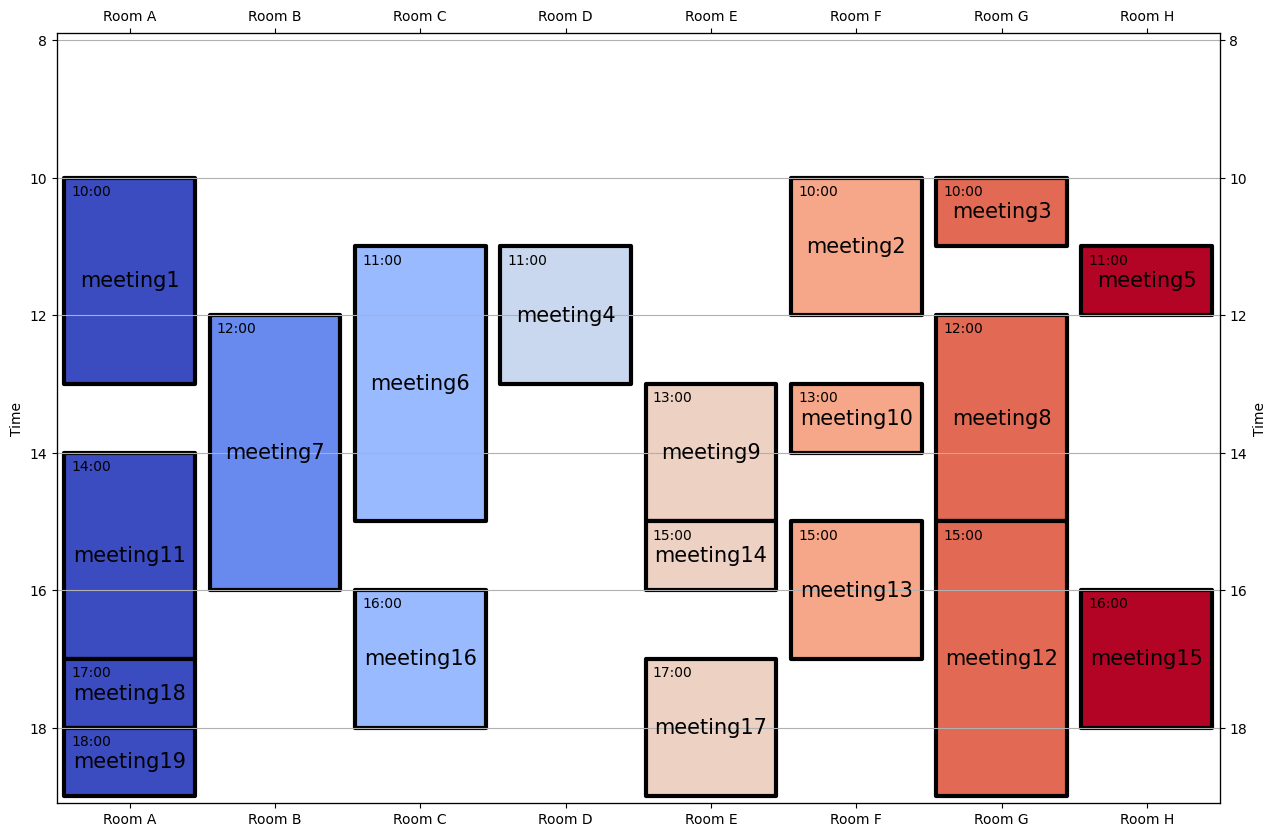

In [14]:
plot_mtg_schedule(num_rooms=Nr, room_assignment=room_assignment)

## いくつかの会議を手動で割り当てる場合
Amplifyでは変数の値を定数値で固定ことができます。この機能を用いて、会議室割り当てを手動で行うことができます。

例えば、バイナリ変数`q[i][j]`の値を1で固定する場合には`q[i][j] = BinaryPoly(1)`とします。右辺の`BinaryPoly(1)`はBinaryPoly型の定数1を表します。

ここでは、

* meeting1 -> Room B
* meeting2 -> Room A
* meeting6 -> Room C
* meeting10 -> Room A
* meeting12 -> Room C
* meeting17 -> Room A

をあらかじめ固定したうえで残りの会議室割り当てを最適化問題として解くことを考えます。



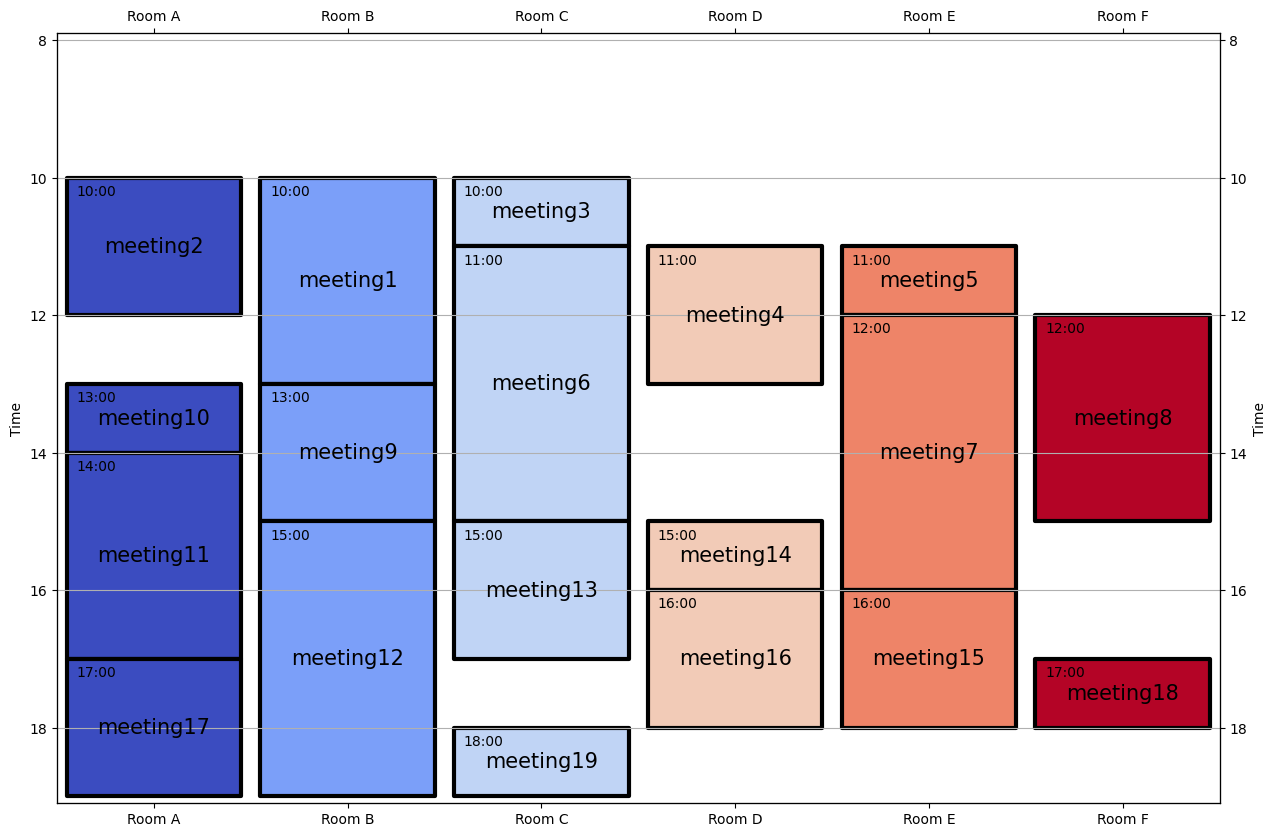

In [17]:
from amplify import BinarySymbolGenerator, BinaryPoly
from amplify.constraint import one_hot, penalty

"""
会議室の名前と対応するインデックス
Room A -> 0, Room B -> 1, Room C -> 2, ...
"""

pre_assign = {
    "meeting1": 1,
    "meeting2": 0,
    "meeting6": 2,
    "meeting10": 0,
    "meeting12": 1,
    "meeting17": 0,
}


Nm = len(schedules)  # 会議の数
Nr = 6  # 会議室の数

gen = BinarySymbolGenerator()
q = gen.array(Nm, Nr)

# あらかじめ割り当てが決まっている会議と会議室の組み合わせに対して、定数を代入する
for mtg_name, room in pre_assign.items():
    mtg_idx = mtg_name2idx[mtg_name]
    for r in range(Nr):
        q[mtg_idx][r] = BinaryPoly(1) if r == room else BinaryPoly(0)

# 一つの会議に一つの会議室を割り当てるための one-hot 制約
room_constraints = sum([one_hot(q[i]) for i in range(Nm)])

# overlaps内の全ての (i, j) で、q[i, r] * q[j, r] = 0 の制約条件を課す
overlap_constraints = sum(
    [sum([penalty(q[i, r] * q[j, r]) for (i, j) in overlaps]) for r in range(Nr)]
)

model = room_constraints + overlap_constraints

from amplify import Solver
from amplify.client import FixstarsClient

# クライアントを設定
client = FixstarsClient()
client.parameters.timeout = 1000  # タイムアウト1秒
# client.token = "xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx"  # ローカル環境で使用する場合は、Amplify AEのアクセストークンを入力してください


solver = Solver(client)  # ソルバーを設定
result = solver.solve(model)  # 問題を解く

# result が空の場合は制約条件が満たされず、解が求まらない
if len(result) == 0:
    raise RuntimeError("Given constraint conditions are not satisfied")


import numpy as np

# 求めた解を元の変数に代入
values = result[0].values
solution = np.array(q.decode(values))

# 各会議がどの会議室に割り当てられるかを読み取る
room_assignment = list(zip(*np.where(solution == 1)))

plot_mtg_schedule(num_rooms=Nr, room_assignment=room_assignment)